# Text Sentiment Analysis using DistilBERT Transformer

Library Imports

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from transformers import DistilBertTokenizerFast, get_scheduler
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob


Device check

In [48]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Data Cleaning & Preprocessing

In [ ]:
# Data cleaning and preprocessing

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    filtered = [word for word in text.split() if word not in stop_words or word in ["not", "no", "n't"]]
    text = ' '.join(filtered)

    if len(text.split()) > 3:
        text = str(TextBlob(text).correct())
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load dataset and sampling

In [50]:
# Load and sample IMDB dataset
dataset = load_dataset("imdb")
small_train_dataset = dataset['train'].shuffle(seed=42).select(range(500))
small_test_dataset = dataset['test'].shuffle(seed=42).select(range(100))

Text Preprocessing

In [51]:
# Apply text preprocessing to both train and test sets
small_train_dataset = small_train_dataset.map(lambda x: {'text': clean_text(x['text'])})
small_test_dataset = small_test_dataset.map(lambda x: {'text': clean_text(x['text'])})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Plot - Data distribution on Test sample

C:\Users\DELL\AppData\Local\Temp\ipykernel_1752\2851171591.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=label_df, x='label', width=0.5, palette='pastel', edgecolor='black')  # width adjusted here


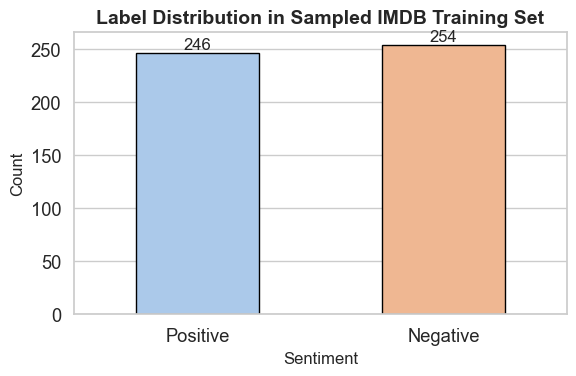

In [95]:
# Prepare label data
labels = [example['label'] for example in small_train_dataset]
label_df = pd.DataFrame(labels, columns=['label'])
label_df['label'] = label_df['label'].map({0: 'Negative', 1: 'Positive'})

# Set a cleaner style
sns.set(style="whitegrid", font_scale=1.2)

# Create count plot with reduced bar width
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=label_df, x='label', width=0.5, palette='pastel', edgecolor='black')  # width adjusted here

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2, p.get_height() + 1), 
                ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title("Label Distribution in Sampled IMDB Training Set", fontsize=14, weight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()


The bar chart shows that the sampled IMDB training dataset is well-balanced, with 246 positive and 254 negative reviews. This balance helps ensure fair and unbiased model training for sentiment classification.

Load Model and Tokenizer

In [53]:
from transformers import DistilBertModel
import torch.nn as nn

class DistilBERTBinaryClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DistilBERTBinaryClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)  # One output logit for BCEWithLogitsLoss

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output.last_hidden_state[:, 0]  # CLS token
        dropped = self.dropout(hidden_state)
        logits = self.classifier(dropped)
        return logits

In [54]:
# Load tokenizer and model
dropout_rate = 0.3
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBERTBinaryClassifier(dropout_rate=dropout_rate).to(device)
model.to(device)

DistilBERTBinaryClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [55]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)

# Tokenize datasets
tokenized_dataset = small_train_dataset.map(tokenize, batched=True)
tokenized_test = small_test_dataset.map(tokenize, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Hyperparameters

In [56]:
# Hyperparameters
EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
DROPOUT = 0.3
EARLY_STOPPING_PATIENCE = 2
MAX_GRAD_NORM = 1.0
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 0

Train Test Split and DataLoad

In [57]:
# Split train/validation
train_size = int(0.8 * len(tokenized_dataset))
val_size = len(tokenized_dataset) - train_size
tokenized_train, tokenized_val = random_split(tokenized_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(tokenized_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(tokenized_val, batch_size=BATCH_SIZE)
test_loader = DataLoader(tokenized_test, batch_size=BATCH_SIZE)


In [58]:
# Optimizer and Scheduler
loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)
num_training_steps = len(train_loader) * EPOCHS
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=num_training_steps,
)



Model Training & Performance Evaluation using Early Stopping

In [ ]:
# Training
best_val_accuracy = 0
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

        # For training accuracy
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
        correct_preds += (preds == labels.int()).sum().item()
        total_preds += labels.size(0)

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_preds / total_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_logits = []
    val_labels = []
    val_loss_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].float().unsqueeze(1).to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss_total += loss.item()

            val_logits.extend(outputs.squeeze().cpu().numpy())
            val_labels.extend(labels.squeeze().cpu().numpy())

    probs = torch.sigmoid(torch.tensor(val_logits))
    val_preds = (probs > 0.5).int().numpy()
    acc = accuracy_score(val_labels, val_preds)
    avg_val_loss = val_loss_total / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(acc)

    print(f"Validation Accuracy: {acc:.4f}")

    # Early stopping
    if acc > best_val_accuracy:
        best_val_accuracy = acc
        patience_counter = 0
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1: 100%|██████████| 25/25 [07:01<00:00, 16.87s/it, loss=0.673]


Validation Accuracy: 0.6400


Epoch 2: 100%|██████████| 25/25 [06:43<00:00, 16.14s/it, loss=0.47] 


Validation Accuracy: 0.7100


Epoch 3: 100%|██████████| 25/25 [06:44<00:00, 16.16s/it, loss=0.261]


Validation Accuracy: 0.7600


Epoch 4: 100%|██████████| 25/25 [06:43<00:00, 16.15s/it, loss=0.275]


Validation Accuracy: 0.7900


Epoch 5: 100%|██████████| 25/25 [06:54<00:00, 16.59s/it, loss=0.208]


Validation Accuracy: 0.7900


Save Model and Tokenizer

In [60]:
# Save final model and tokenizer
torch.save(model.state_dict(), "models/best_model.pt")
tokenizer.save_pretrained("models/tokenizer/")

('models/tokenizer/tokenizer_config.json',
 'models/tokenizer/special_tokens_map.json',
 'models/tokenizer/vocab.txt',
 'models/tokenizer/added_tokens.json',
 'models/tokenizer/tokenizer.json')

Model Evaluation and Performance Metrics

In [ ]:
model.load_state_dict(torch.load("models/best_model.pt"))
model.eval()

all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)

        logits = model(input_ids, attention_mask)
        all_logits.extend(logits.squeeze().cpu().numpy())
        all_labels.extend(labels.squeeze().cpu().numpy())

# Apply sigmoid + threshold
probs = torch.sigmoid(torch.tensor(all_logits))
preds = (probs > 0.5).int().numpy()


In [62]:
# Metrics
accuracy = accuracy_score(all_labels, preds)
precision = precision_score(all_labels, preds)
recall = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
cm = confusion_matrix(all_labels, preds)

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"Confusion Matrix:\n{cm}")

Test Accuracy:  0.7900
Precision:      0.7321
Recall:         0.8723
F1 Score:       0.7961
Confusion Matrix:
[[38 15]
 [ 6 41]]


Visualizations

In [108]:
# Loss curve plot
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, marker='o', linestyle='-', label='Train Loss')
    plt.plot(val_losses, marker='s', linestyle='--', label='Validation Loss')
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Training vs Validation Loss', fontsize=12, weight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Accuracy curve plot
def plot_accuracy_curve(train_accuracies, val_accuracies):
    plt.figure(figsize=(6, 4))
    plt.plot(train_accuracies, marker='o', linestyle='-', label='Train Accuracy')
    plt.plot(val_accuracies, marker='s', linestyle='--', label='Validation Accuracy')
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Training vs Validation Accuracy', fontsize=12, weight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"],
                linewidths=0.5, linecolor='gray')
    plt.xlabel("Predicted", fontsize=10)
    plt.ylabel("Actual", fontsize=10)
    plt.title("Confusion Matrix", fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()

# Classification report as DataFrame
def classification_report_table(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, target_names=["Negative", "Positive"])
    df_report = pd.DataFrame(report).transpose().round(3)
    return df_report


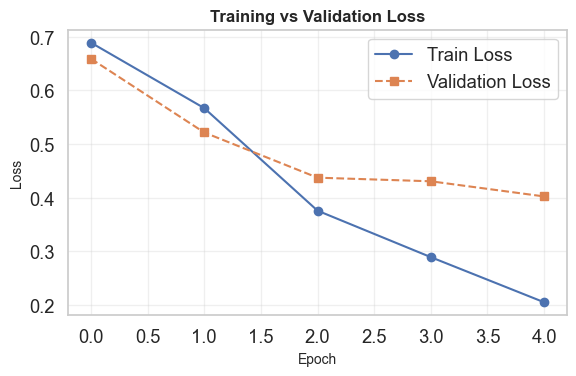

In [109]:
# Training/Validation Loss Curve
plot_loss_curve(train_losses, val_losses)

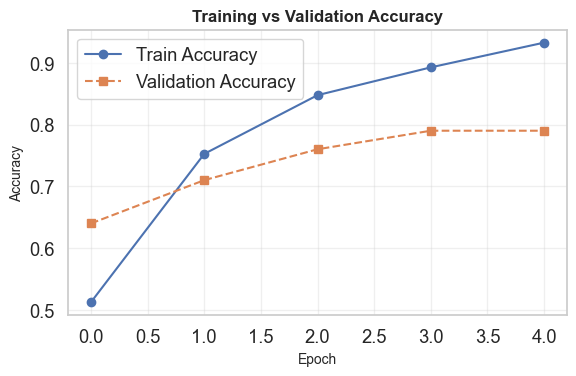

In [103]:
# Accuracy over epochs
plot_accuracy_curve(train_accuracies, val_accuracies)

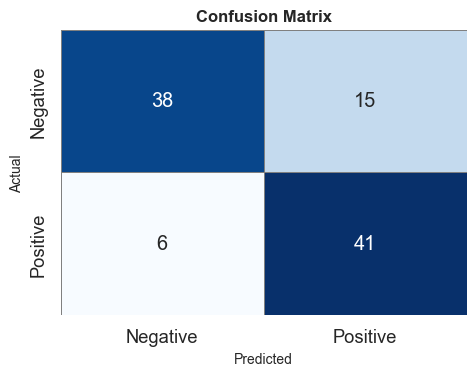

In [104]:
# confusion matrix
plot_confusion_matrix(all_labels, preds)

In [105]:
# classification report
report_df = classification_report_table(all_labels, preds)
print(report_df)

              precision  recall  f1-score  support
Negative          0.864   0.717     0.784    53.00
Positive          0.732   0.872     0.796    47.00
accuracy          0.790   0.790     0.790     0.79
macro avg         0.798   0.795     0.790   100.00
weighted avg      0.802   0.790     0.789   100.00


Sentiment Prediction

In [91]:
def predict_sentiment(text):
    import re
    from torch.nn.functional import sigmoid
    from nltk.corpus import words
    english_words = set(words.words())

    raw_input = text.strip()
    if not raw_input:
        return "❌ Invalid input: Please enter some text."

    # Clean and validate
    text = clean_text(raw_input)
    if not text:
        return "❌ Invalid input: Please enter a meaningful sentence."

    # Token check
    tokens = tokenizer.tokenize(text)
    if not tokens or tokens == ['[UNK]']:
        return "❌ Invalid input: Please enter a meaningful sentence."

    # Language realism check: does it contain any real English words?
    real_words = [word for word in text.lower().split() if word in english_words]
    if len(real_words) == 0:
        return "❌ Invalid input: Your input doesn't contain recognizable English words."

    # Prediction
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        prob = sigmoid(outputs).item()
        pred = 1 if prob > 0.50 else 0

    return "😊 Positive" if pred == 1 else "😞 Negative"


Test Cases

In [88]:
example_review = "This movie was absolutely fantastic, with great performances!"
gibberish_input = "VABSJVASJKVAS"

print(f"\nTest Review Sentiment:\nInput: {example_review} :: Sentiment: {predict_sentiment(example_review)}")
print(f"Input: {gibberish_input} :: Sentiment: {predict_sentiment(gibberish_input)}")


Test Review Sentiment:
Input: This movie was absolutely fantastic, with great performances! :: Sentiment: 😊 Positive
Input: VABSJVASJKVAS :: Sentiment: ❌ Invalid input: Your input doesn't contain recognizable English words.


In [ ]:
print("Input: Blank Space - ",predict_sentiment(""))  # Empty input
print("Input: Token Fragment - ", predict_sentiment("##"))  # Token fragments only
print("Input: Short Valid inputs - ", predict_sentiment("Good"))  # Extremely short but valid input


Input: Blank Space -  ❌ Invalid input: Please enter some text.
Input: Token Fragment -  ❌ Invalid input: Please enter a meaningful sentence.
Input: Short Valid inputs -  😊 Positive
😊 Positive
😞 Negative
❌ Invalid input: Your input doesn't contain recognizable English words.


In [ ]:
print(predict_sentiment("Wonderful movie!"))
print(predict_sentiment("Horrible and slow."))
print(predict_sentiment("VABSJVASJKVAS"))

User Interface to Test Predictions

In [90]:
import gradio as gr

gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter a movie review...", label="Movie Review"),
    outputs=gr.Text(label="Sentiment"),
    title="🎬 Movie Review Sentiment Analyzer",
    description="Enter a movie review below and get the predicted sentiment using a fine-tuned DistilBERT model. Gibberish will be rejected politely!"
).launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.
